### New Projections

After adding 4 more clock mice and identifying an issue with the roi tracking, we rerun our analyses of the clock experiments

In [29]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf

import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Clock-D19-EPM/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
c19_epm_file = "/work/mk423/Clock-D19-EPM/Complete_C19_EPM_Data.pkl"
proj_file = PROJECT_PATH + "complete_may_2024_c19_epm_projection.csv"
bxcx_proj_file = PROJECT_PATH + "complete_may_2024_bxcx_c19_epm_projection.csv"

mean_file = PROJECT_PATH + "complete_may_2024_c19_epm_mean_scores.csv"
bxcx_mean_file = PROJECT_PATH + "complete_may_2024_bxcx_c19_epm_mean_scores.csv"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"


FEATURE_LIST = ['X_psd','X_coh','X_gc']
FEATURE_WEIGHT = [10,1,1]

def get_3_net_aucs(s,y,y_group=None):
    
    auc_mean_list = []
    auc_stderr_list =[]
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        mean = np.mean([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"])
        stderr = np.std([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"]) / np.sqrt(len(auc_dict.keys()))
        
        auc_mean_list.append(mean)
        auc_stderr_list.append(stderr)
        
    return auc_mean_list, auc_stderr_list

def get_3_net_auc_dict(s,y,y_group=None):
    auc_dict_list = []
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        auc_dict_list.append(auc_dict)
        
    return auc_dict_list


In [26]:
dataDict = pickle.load(open(c19_epm_file,"rb"))

X = np.hstack([weight*dataDict[feature] for weight,feature in zip(FEATURE_WEIGHT,FEATURE_LIST)])
y_time = dataDict['y_time']
y_mouse = np.array(dataDict['y_mouse'])
y_condition = np.array(dataDict["y_geno"])
y_task = 1-dataDict['y_hc']
y_roi = dataDict["y_roi"]
y_expDate = dataDict['y_expDate']
#y_sex = np.array(dataDict['y_sex'])
s = model.project(X)

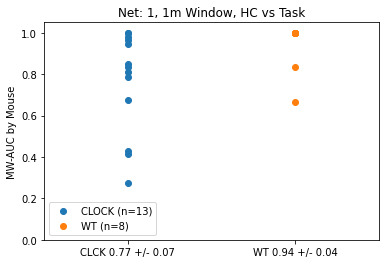

CLOCK Data Points [0.4166666666666667, 0.9666666666666667, 0.42857142857142855, 0.9444444444444444, 0.7857142857142857, 0.8125, 0.9777777777777777, 0.8472222222222222, 0.6727272727272727, 0.2727272727272727, 0.8333333333333334, 1.0, 1.0]
WT Data Points [1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0]


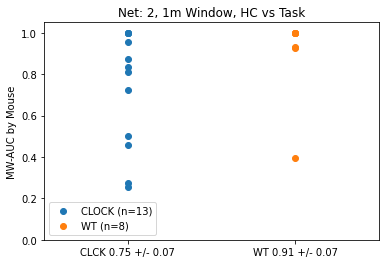

CLOCK Data Points [0.4583333333333333, 1.0, 0.2571428571428571, 0.7222222222222222, 0.5, 0.8125, 0.9555555555555556, 0.875, 1.0, 0.2727272727272727, 0.8333333333333334, 1.0, 1.0]
WT Data Points [1.0, 1.0, 0.3939393939393939, 0.9259259259259259, 1.0, 1.0, 0.9333333333333333, 1.0]


In [28]:
for net in range(2):
    auc_list = []
    auc_list_WT = []
    for mouse in np.unique(y_mouse):
        #print(mouse)
        mouse_mask = y_mouse==mouse

        s_mouse = s[mouse_mask==1,net]
        y_task_mouse = y_task[mouse_mask==1]
        y_cond_mouse = y_condition[mouse_mask==1][0]
        
        
        temp_s = s_mouse[:-int(s_mouse.shape[0]%60)].reshape(-1,60)
        temp_y = y_task_mouse[:-int(y_task_mouse.shape[0]%60)].reshape(-1,60)

        temp_s = np.mean(temp_s,axis=1)
        temp_y = np.mean(temp_y,axis=1) > 0.5
        auc, pval = model.mw_auc(temp_s,temp_y)

        if y_cond_mouse==1:
            auc_list.append(auc)
        else:
            auc_list_WT.append(auc)
        

    plt.scatter(np.ones(len(auc_list)),auc_list,label="CLOCK (n={})".format(len(auc_list)))
    plt.scatter(np.ones(len(auc_list_WT))*2,auc_list_WT,label="WT (n={})".format(len(auc_list_WT)))
    
    plt.title("Net: {}, 1m Window, HC vs Task".format(net+1))
    plt.ylim([0,1.05])
    plt.xlim([0.5,2.5])
    plt.xticks([1,2],["CLCK {:.2f} +/- {:.2f}".format(np.mean(auc_list),np.std(auc_list)/np.sqrt(len(auc_list))),"WT {:.2f} +/- {:.2f}".format(np.mean(auc_list_WT),np.std(auc_list_WT)/np.sqrt(len(auc_list_WT)))])
    plt.ylabel("MW-AUC by Mouse")
    plt.legend()
    plt.show()
            
    print("CLOCK Data Points",auc_list)
    print("WT Data Points",auc_list_WT)

In [30]:
all_hc_v_task_aucs = model.score(X,y_task,y_mouse,return_dict=True)
all_hc_v_task_aucs_3_net = get_3_net_auc_dict(s,y_task,y_mouse)
coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())
agg_score = s[:,:3] @ coeffs

results_dict = {
    "agg score":agg_score,
    "net 1 scores":s[:,0],
    "net 2 scores":s[:,1],
    "net 3 scores":s[:,2],
    "mouse":y_mouse,
    #"sex":y_sex,
    "roi":y_roi,
    "condition (1:CLOCK,0:WT)":y_condition,
    "in-task":y_task,
    "time":y_time,
    "expDate":y_expDate,
    "hc_v_task auc":[all_hc_v_task_aucs[mouse][0] for mouse in y_mouse],
    "net 1 hc_v_task auc":[all_hc_v_task_aucs_3_net[0][mouse][0] for mouse in y_mouse],
    "net 2 hc_v_task auc":[all_hc_v_task_aucs_3_net[1][mouse][0] for mouse in y_mouse],
    "net 3 hc_v_task auc":[all_hc_v_task_aucs_3_net[2][mouse][0] for mouse in y_mouse],
}

df = pd.DataFrame.from_dict(results_dict)
df.to_csv(proj_file)
df.head()

,agg score,net 1 scores,net 2 scores,net 3 scores,mouse,roi,"condition (1:CLOCK,0:WT)",in-task,time,expDate,hc_v_task auc,net 1 hc_v_task auc,net 2 hc_v_task auc,net 3 hc_v_task auc
0,5.505884,0.133097,0.248273,0.086571,Mouse0911,NaN,0.0,0.0,1,022021,0.702284,0.619013,0.716532,0.619504
1,3.841483,0.113681,0.160648,0.068322,Mouse0911,NaN,0.0,0.0,3,022021,0.702284,0.619013,0.716532,0.619504
2,5.850778,0.132260,0.269141,0.093692,Mouse0911,NaN,0.0,0.0,4,022021,0.702284,0.619013,0.716532,0.619504
3,2.884168,0.052870,0.139675,0.051756,Mouse0911,NaN,0.0,0.0,5,022021,0.702284,0.619013,0.716532,0.619504
4,2.567462,0.071152,0.111259,0.021368,Mouse0911,NaN,0.0,0.0,6,022021,0.702284,0.619013,0.716532,0.619504


In [32]:
#Get per mouse average scores, average scores in HC and average scores in EPM
mouse_list = []
avg_score_list = []
avg_hc_score_list = []
avg_task_score_list = []
condition_list = []
sex_list = []


#if boxcox
bxcx=False
bxcx_s = []
if bxcx:
    for i in range(s.shape[1]):
        bxcx_s.append(boxcox(20*s[:,i])[0].reshape(-1,1))
    
    bxcx_s = np.hstack(bxcx_s)

    
    for mouse in np.unique(y_mouse):
        mouse_mask = y_mouse==mouse
        hc_mouse_mask = np.logical_and(mouse_mask,y_task==0)
        task_mouse_mask = np.logical_and(mouse_mask,y_task==1)
        avg_score = np.mean(bxcx_s[mouse_mask==1,:3],axis=0)
        avg_score_hc = np.mean(bxcx_s[hc_mouse_mask==1,:3],axis=0)
        avg_score_task = np.mean(bxcx_s[task_mouse_mask==1,:3],axis=0)

        mouse_list.append(mouse)
        avg_score_list.append(avg_score)
        avg_hc_score_list.append(avg_score_hc)
        avg_task_score_list.append(avg_score_task)
        condition_list.append(np.unique(y_condition[y_mouse==mouse])[0])
        #sex_list.append(np.unique(y_sex[y_mouse==mouse])[0])
else:
    for mouse in np.unique(y_mouse):
        mouse_mask = y_mouse==mouse
        hc_mouse_mask = np.logical_and(mouse_mask,y_task==0)
        task_mouse_mask = np.logical_and(mouse_mask,y_task==1)
        avg_score = np.mean(s[mouse_mask==1,:3],axis=0)
        avg_score_hc = np.mean(s[hc_mouse_mask==1,:3],axis=0)
        avg_score_task = np.mean(s[task_mouse_mask==1,:3],axis=0)

        mouse_list.append(mouse)
        avg_score_list.append(avg_score)
        avg_hc_score_list.append(avg_score_hc)
        avg_task_score_list.append(avg_score_task)
        condition_list.append(np.unique(y_condition[y_mouse==mouse])[0])
        #sex_list.append(np.unique(y_sex[y_mouse==mouse])[0])
    
avg_score_list = np.array(avg_score_list)
avg_hc_score_list = np.array(avg_hc_score_list)
avg_task_score_list = np.array(avg_task_score_list)

coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())

mag_score_list = avg_score_list*coeffs
mag_hc_score_list = avg_hc_score_list*coeffs
mag_task_score_list = avg_task_score_list*coeffs

net_impact_scores = mag_score_list / np.sum(mag_score_list,axis=1).reshape(-1,1)
net_hc_scores = mag_hc_score_list / np.sum(mag_hc_score_list,axis=1).reshape(-1,1)
net_task_scores = mag_task_score_list / np.sum(mag_task_score_list,axis=1).reshape(-1,1)

proj_dict = {
    "mouse":mouse_list,
    "condition (1:CLOCK,0:WT)":condition_list,
    "composite avgScore":np.sum(mag_score_list,axis=1),
    "composite avgHCScore":np.sum(mag_hc_score_list,axis=1),
    "composite avgTaskScore":np.sum(mag_task_score_list,axis=1),
    
    "net 1 avgScore":avg_score_list[:,0],
    "net 1 avgHCScore":avg_hc_score_list[:,0],
    "net 1 avgTaskScore":avg_task_score_list[:,0],
    "net 2 avgScore":avg_score_list[:,1],
    "net 2 avgHCScore":avg_hc_score_list[:,1],
    "net 2 avgTaskScore":avg_task_score_list[:,1],
    "net 3 avgScore":avg_score_list[:,2],
    "net 3 avgHCScore":avg_hc_score_list[:,2],
    "net 3 avgTaskScore":avg_task_score_list[:,2],
}
df_means = pd.DataFrame.from_dict(proj_dict)
df_means.to_csv(mean_file)
df_means.head()

,mouse,"condition (1:CLOCK,0:WT)",composite avgScore,composite avgHCScore,composite avgTaskScore,net 1 avgScore,net 1 avgHCScore,net 1 avgTaskScore,net 2 avgScore,net 2 avgHCScore,net 2 avgTaskScore,net 3 avgScore,net 3 avgHCScore,net 3 avgTaskScore
0,Mouse0911,0.0,3.732661,3.339579,4.192368,0.096208,0.090969,0.102336,0.164463,0.144146,0.188225,0.066528,0.062386,0.071371
1,Mouse0912,1.0,2.251586,2.411067,2.189356,0.048852,0.060991,0.044116,0.102831,0.106351,0.101457,0.080900,0.055875,0.090665
2,Mouse0913,1.0,3.382048,2.714567,3.589009,0.063710,0.047505,0.068735,0.162591,0.132039,0.172064,0.065034,0.065949,0.064750
3,Mouse0914,0.0,4.239820,3.481134,4.458719,0.109899,0.093063,0.114756,0.187306,0.152016,0.197489,0.055732,0.048321,0.057870
4,Mouse2401,1.0,3.407870,3.535969,3.318642,0.082424,0.084263,0.081142,0.153107,0.159809,0.148439,0.065932,0.063630,0.067536


## Dynamics

In [33]:
df_full = pd.read_csv(proj_file)
df_in_task = df_full[df_full['in-task']==1].copy()
df_in_hc = df_full[df_full['in-task']==0].copy()
df_mean_scores = pd.read_csv(mean_file)

In [34]:
ca_mask = np.logical_or(df_in_task.roi==1,
                df_in_task.roi==3
              )

df_ca = df_in_task[ca_mask==1]
df_ca.to_csv(PROJECT_PATH + "complete_may_2024_clock_in_closed_arms.csv",index=False)

In [35]:
df_ca

,Unnamed: 0,agg score,net 1 scores,net 2 scores,net 3 scores,mouse,roi,"condition (1:CLOCK,0:WT)",in-task,time,expDate,hc_v_task auc,net 1 hc_v_task auc,net 2 hc_v_task auc,net 3 hc_v_task auc
71,71,4.620808,0.081265,0.228220,0.027081,Mouse0911,1.0,0.0,1.0,240,22021,0.702284,0.619013,0.716532,0.619504
73,73,5.907523,0.144493,0.265322,0.094536,Mouse0911,1.0,0.0,1.0,282,22021,0.702284,0.619013,0.716532,0.619504
74,74,3.388041,0.093539,0.145364,0.066500,Mouse0911,1.0,0.0,1.0,294,22021,0.702284,0.619013,0.716532,0.619504
76,76,4.011284,0.085611,0.186111,0.096222,Mouse0911,1.0,0.0,1.0,320,22021,0.702284,0.619013,0.716532,0.619504
77,77,6.546325,0.113240,0.321747,0.100186,Mouse0911,1.0,0.0,1.0,324,22021,0.702284,0.619013,0.716532,0.619504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14711,14711,1.901901,0.083143,0.063512,0.039488,Mouse67162,3.0,1.0,1.0,666,50324,0.454380,0.436139,0.464810,0.597424
14712,14712,2.484688,0.080250,0.100720,0.026674,Mouse67162,3.0,1.0,1.0,667,50324,0.454380,0.436139,0.464810,0.597424
14713,14713,1.878358,0.075144,0.066191,0.053493,Mouse67162,3.0,1.0,1.0,668,50324,0.454380,0.436139,0.464810,0.597424
14714,14714,2.380217,0.082358,0.092129,0.051725,Mouse67162,3.0,1.0,1.0,669,50324,0.454380,0.436139,0.464810,0.597424


In [38]:
geno_map = {}

for mouse in np.unique(df_in_task.mouse):
    geno = df_in_task[df_in_task.mouse==mouse]["condition (1:CLOCK,0:WT)"].values[0]
    geno_map[mouse] = geno
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice


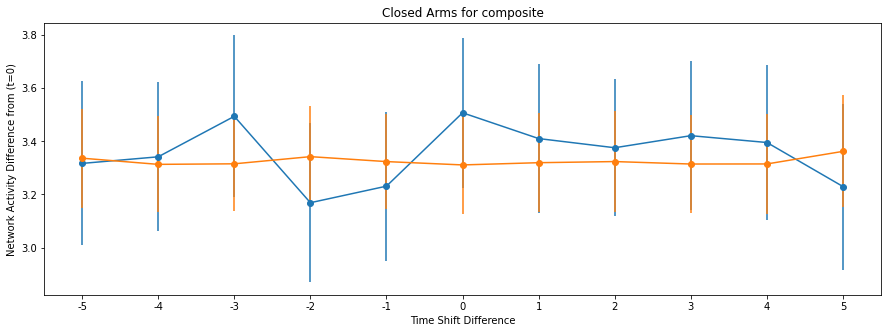

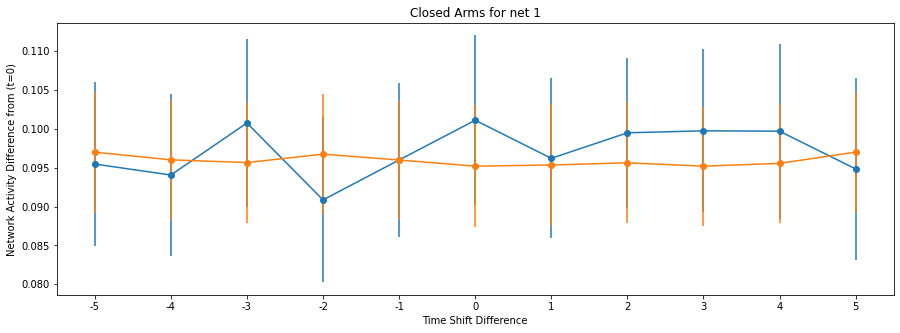

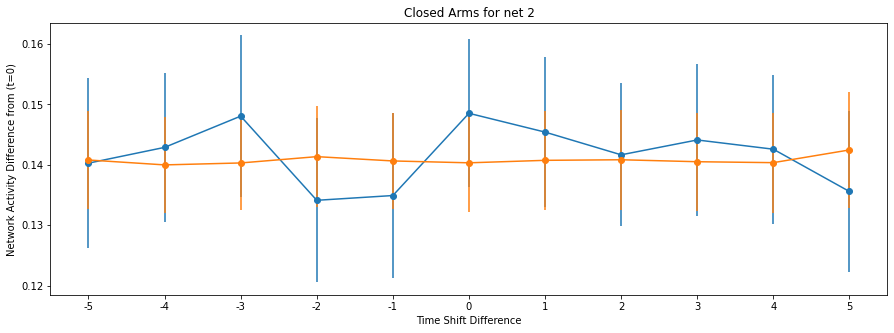

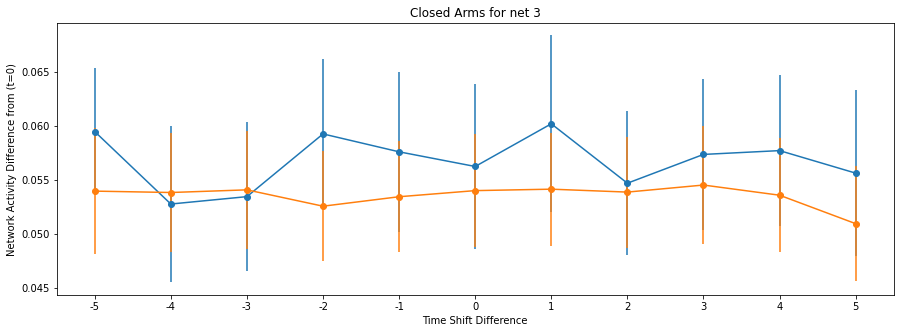

,mouse,geno,location,network,mean task score,mean hc score,-5,-4,-3,-2,-1,0,1,2,3,4,5
0,Mouse0911,0.0,oa,composite,4.192368,3.339579,NaN,2.693797,NaN,NaN,NaN,4.020968,NaN,NaN,NaN,NaN,NaN
1,Mouse0912,1.0,oa,composite,2.189356,2.411067,2.168549,1.739644,1.850942,2.06056,1.956661,1.681697,1.926417,2.101766,2.294167,2.029516,1.870678
2,Mouse0913,1.0,oa,composite,3.589009,2.714567,3.691408,3.754129,3.951663,3.906546,3.935129,3.862683,3.942463,3.988453,4.012769,3.975562,3.966465
3,Mouse0914,0.0,oa,composite,4.458719,3.481134,4.830598,4.876836,4.931846,4.996288,5.266876,4.787043,4.978075,4.962586,4.745548,4.960363,4.772514
4,Mouse2401,1.0,oa,composite,3.318642,3.535969,NaN,NaN,NaN,1.713415,2.58985,2.972559,2.478833,NaN,NaN,1.917251,2.247104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,Mouse69841,1.0,ca,net 3,0.034818,0.037393,0.035785,0.036,0.036163,0.037933,0.037552,0.037513,0.037243,0.036265,0.035634,0.034899,0.034071
38,Mouse69861,0.0,ca,net 3,0.031028,0.029201,0.031544,0.031531,0.031405,0.031685,0.031641,0.031663,0.031425,0.031867,0.031637,0.03148,0.031382
39,Mouse69862,0.0,ca,net 3,0.038106,0.041945,0.037663,0.037863,0.038116,0.038614,0.038813,0.038662,0.038437,0.038519,0.038691,0.038383,0.038402
40,Mouse69872,1.0,ca,net 3,0.037093,0.043621,0.036895,0.036893,0.036432,0.03634,0.036347,0.036519,0.035834,0.035214,0.035792,0.035375,0.034527


In [60]:
num_mice=np.unique(df_in_task.mouse).shape[0]

sliding_avg_size=5

allMice_oa_means = []
allMice_ca_means = []

allDiffs_oa = []
allDiffs_ca = []
for mouse in np.unique(df_in_task.mouse):
    
    #print(mouse)
    mouse_mask = df_in_task.mouse==mouse
    nan_filter = 1-np.isnan(df_in_task.roi)
    mask = np.logical_and(mouse_mask,nan_filter)
    
    in_open_arms = np.logical_or(df_in_task[mask==1]["roi"].values==2,
                                 df_in_task[mask==1]["roi"].values==4)
    
    in_closed_arms = np.logical_or(df_in_task[mask==1]["roi"].values==1,
                                   df_in_task[mask==1]["roi"].values==3)
    
    mouse_time = df_in_task[mask==1]["time"].values
    mouse_roi = df_in_task[mask==1]["roi"].values
    
    nagg_s = df_in_task[mask==1]["agg score"].values
    n1_s = df_in_task[mask==1]["net 1 scores"].values
    n2_s = df_in_task[mask==1]["net 2 scores"].values
    n3_s = df_in_task[mask==1]["net 3 scores"].values
    
    mouse_oa_avgs = []
    mouse_ca_avgs = []
    mouse_avgs = []
    
    oa_centers = []
    ca_centers = []
    all_times = []
    for idx, roi in enumerate(mouse_roi):
        if idx > sliding_avg_size and idx < (len(mouse_roi) - sliding_avg_size):
            
            nagg_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n1_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n2_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n3_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            
            center_time = mouse_time[idx]
            start_time = center_time - sliding_avg_size
            end_time = center_time + sliding_avg_size
            cont_time = np.arange(start_time,end_time+1)
            
            actual_time = mouse_time[idx-sliding_avg_size:idx+sliding_avg_size+1]
            
            actual_nagg_scores = nagg_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n1_scores = n1_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n2_scores = n2_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n3_scores = n3_s[idx-sliding_avg_size:idx+sliding_avg_size+1]

            for i,time in enumerate(cont_time):
                if time in actual_time:
                    temp_mask = actual_time==time
                    nagg_slice[i] = actual_nagg_scores[temp_mask==1][0]
                    n1_slice[i] = actual_n1_scores[temp_mask==1][0]
                    n2_slice[i] = actual_n2_scores[temp_mask==1][0]
                    n3_slice[i] = actual_n3_scores[temp_mask==1][0]
                    
            slice_means = [nagg_slice,
                           n1_slice,
                           n2_slice,
                           n3_slice]
            
            all_times.append(center_time)
            mouse_avgs.append(np.array(slice_means))
            #if in the open arms
            if roi==2 or roi==4: 
                mouse_oa_avgs.append(slice_means)
                oa_centers.append(center_time)
            #if in the closed arms
            elif roi==1 or roi==3: 
                mouse_ca_avgs.append(slice_means)
                ca_centers.append(center_time)
            
    if len(mouse_oa_avgs) >0:
        mouse_oa_slice_mean = np.nanmean(mouse_oa_avgs,axis=0)
    else:
        mouse_oa_slice_mean = np.zeros((4,11))*np.nan
    mouse_ca_slice_mean = np.nanmean(mouse_ca_avgs,axis=0)
    
    #print(len(mouse_oa_avgs))
    allMice_oa_means.append(mouse_oa_slice_mean)
    allMice_ca_means.append(mouse_ca_slice_mean)
    
    
allMice_oa_means = np.array(allMice_oa_means)
allMice_ca_means = np.array(allMice_ca_means)

df_list = []
for i, net in zip(range(4),["composite","net 1","net 2","net 3"]):
    
    plt.figure(figsize=(15,5))
    #shared_meanish = np.nanmean(allMice_oa_means,axis=0)[i][5] / 2 + np.nanmean(allMice_ca_means,axis=0)[i][5] / 2
    #plt.subplot(1,2,1)
    oa_mean = np.nanmean(allMice_oa_means,axis=0)
    oa_stderr = np.nanstd(allMice_oa_means,axis=0) / np.sqrt(11)

    plt.errorbar(np.arange(11),oa_mean[i,:],yerr=oa_stderr[i,:],fmt="-o", label="Open Arms")
    plt.xticks(np.arange(11), np.arange(11)-5)
    plt.title("Open Arms for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    #plt.subplot(1,2,2)
    ca_mean = np.nanmean(allMice_ca_means,axis=0)
    ca_stderr = np.nanstd(allMice_ca_means,axis=0) / np.sqrt(11)

    plt.errorbar(np.arange(11),ca_mean[i,:],yerr=ca_stderr[i,:],fmt="-o", label="Closed Arms")
    plt.xticks(np.arange(11), np.arange(11)-5)
    plt.title("Closed Arms for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    plt.show()
    
    ctr_surr_mat = np.vstack([allMice_oa_means[:,i,:],
                              allMice_ca_means[:,i,:]])
    mice = np.vstack([np.unique(df_in_task.mouse).reshape(-1,1),
                      np.unique(df_in_task.mouse).reshape(-1,1)])
    
    geno = np.vstack([np.array([geno_map[mouse] for mouse in np.unique(df_in_task.mouse)]).reshape(-1,1),
                      np.array([geno_map[mouse] for mouse in np.unique(df_in_task.mouse)]).reshape(-1,1)])
    
    mean_net_intask_scores = np.vstack([np.array([df_mean_scores[df_mean_scores.mouse==mouse]["{} avgTaskScore".format(net)] for mouse in np.unique(df_in_task.mouse)]).reshape(-1,1),
                                       np.array([df_mean_scores[df_mean_scores.mouse==mouse]["{} avgTaskScore".format(net)] for mouse in np.unique(df_in_task.mouse)]).reshape(-1,1)])
    
    mean_net_hc_scores = np.vstack([np.array([df_mean_scores[df_mean_scores.mouse==mouse]["{} avgHCScore".format(net)] for mouse in np.unique(df_in_task.mouse)]).reshape(-1,1),
                                       np.array([df_mean_scores[df_mean_scores.mouse==mouse]["{} avgHCScore".format(net)] for mouse in np.unique(df_in_task.mouse)]).reshape(-1,1)])
    #mean_net_surr_scores = np.vstack([mean_oa_scores[i,:].reshape(-1,1),
    #                                  mean_ca_scores[i,:].reshape(-1,1)])
    
    ctr_vs_surr = np.hstack([["oa" for _ in range(num_mice)],
                             ["ca" for _ in range(num_mice)]]).reshape(-1,1)
    
    net_number = np.hstack([[net for _ in range(num_mice)],
                             [net for _ in range(num_mice)]]).reshape(-1,1)
    
    saveData = np.hstack([mice,geno,ctr_vs_surr,net_number,mean_net_intask_scores,mean_net_hc_scores,ctr_surr_mat]).astype(object)
    
    df_saveData = pd.DataFrame(saveData,
                               columns = ["mouse","geno","location","network","mean task score","mean hc score"] + list(np.arange(-5,6).astype(str)))
    
    df_list.append(df_saveData)
    
df_complete = pd.concat(df_list)
df_complete.to_csv(PROJECT_PATH + "complete_may_2024_CLOCKs_0s_filterd_CLOCK_BalbC_EPM_11s_slice_data.csv")
df_complete

Mouse0911
Mouse0912
Mouse0913
Mouse0914


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: Mean of empty slice


Mouse2401
Mouse2402
Mouse2403
Mouse30391
Mouse30392
Mouse3881
Mouse3882
Mouse3883
Mouse67151
Mouse67152
Mouse67161
Mouse67162
Mouse69841
Mouse69861
Mouse69862
Mouse69872
Mouse69873


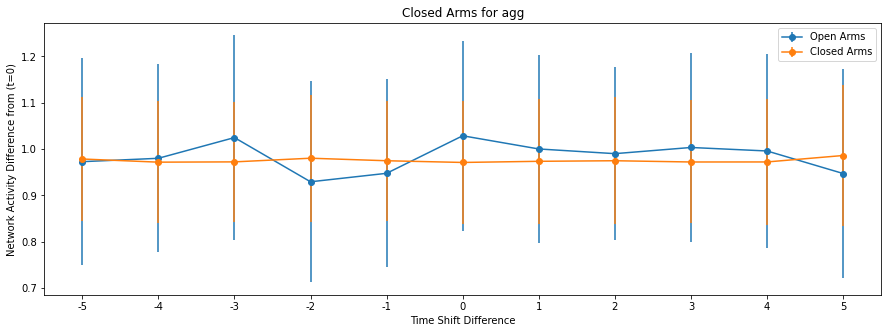

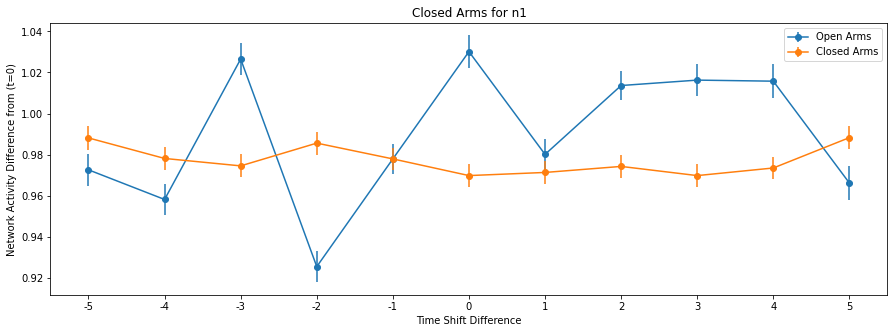

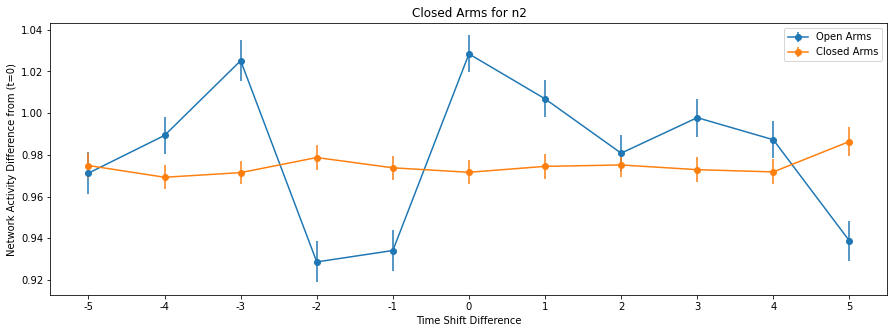

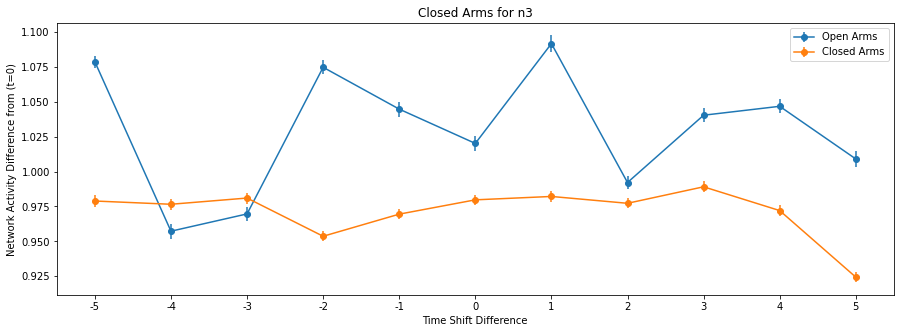

In [56]:
sliding_avg_size=5

allMice_oa_means = []
allMice_ca_means = []

oa_mice_list = []
ca_mice_list = []

oa_geno_list = []
ca_geno_list = []

allDiffs_oa = []
allDiffs_ca = []
for mouse in np.unique(df_in_task.mouse):
    
    print(mouse)
    mouse_mask = df_in_task.mouse==mouse
    nan_filter = 1 - np.isnan(df_in_task.roi)
    mask = np.logical_and(mouse_mask,nan_filter)
    
    in_open_arms = np.logical_or(df_in_task[mask==1]["roi"].values==2,
                                 df_in_task[mask==1]["roi"].values==4)
    
    in_closed_arms = np.logical_or(df_in_task[mask==1]["roi"].values==1,
                                   df_in_task[mask==1]["roi"].values==3)
    
    mouse_time = df_in_task[mask==1]["time"].values
    mouse_roi = df_in_task[mask==1]["roi"].values
    
    nagg_s = df_in_task[mask==1]["agg score"].values
    n1_s = df_in_task[mask==1]["net 1 scores"].values
    n2_s = df_in_task[mask==1]["net 2 scores"].values
    n3_s = df_in_task[mask==1]["net 3 scores"].values
    geno = df_in_task[mask==1]["condition (1:CLOCK,0:WT)"].values[0]
    
    mouse_oa_avgs = []
    mouse_ca_avgs = []
    mouse_avgs = []
    
    oa_centers = []
    ca_centers = []
    all_times = []
    for idx, roi in enumerate(mouse_roi):
        if idx > sliding_avg_size and idx < (len(mouse_roi) - sliding_avg_size):
            
            nagg_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n1_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n2_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n3_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            
            center_time = mouse_time[idx]
            start_time = center_time - sliding_avg_size
            end_time = center_time + sliding_avg_size
            cont_time = np.arange(start_time,end_time+1)
            
            actual_time = mouse_time[idx-sliding_avg_size:idx+sliding_avg_size+1]
            
            actual_nagg_scores = nagg_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n1_scores = n1_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n2_scores = n2_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n3_scores = n3_s[idx-sliding_avg_size:idx+sliding_avg_size+1]

            for i,time in enumerate(cont_time):
                if time in actual_time:
                    temp_mask = actual_time==time
                    nagg_slice[i] = actual_nagg_scores[temp_mask==1][0]
                    n1_slice[i] = actual_n1_scores[temp_mask==1][0]
                    n2_slice[i] = actual_n2_scores[temp_mask==1][0]
                    n3_slice[i] = actual_n3_scores[temp_mask==1][0]
                    
            slice_means = [nagg_slice,
                           n1_slice,
                           n2_slice,
                           n3_slice]
            
            all_times.append(center_time)
            mouse_avgs.append(np.array(slice_means))
            #if in the open arms
            if roi==2 or roi==4: 
                mouse_oa_avgs.append(slice_means)
                oa_centers.append(center_time)
            #if in the closed arms
            elif roi==1 or roi==3: 
                mouse_ca_avgs.append(slice_means)
                ca_centers.append(center_time)
            
    if len(oa_centers) > 0:# and mouse!="Mouse69861":
        mouse_oa_slice_mean = np.nanmean(mouse_oa_avgs,axis=0)
        allMice_oa_means.append(mouse_oa_slice_mean)
        oa_mice_list.append(mouse)
        oa_geno_list.append(geno)
    
    if len(ca_centers) > 0:# and mouse!="Mouse69861":
        mouse_ca_slice_mean = np.nanmean(mouse_ca_avgs,axis=0)
        allMice_ca_means.append(mouse_ca_slice_mean)
        ca_mice_list.append(mouse)
        ca_geno_list.append(geno)
    
for i, net in zip(range(4),["agg","n1","n2","n3"]):

    plt.figure(figsize=(15,5))
    shared_meanish = np.mean(allMice_oa_means,axis=0)[i][5] / 2 + np.mean(allMice_ca_means,axis=0)[i][5] / 2
    #plt.subplot(1,2,1)
    oa_mean = np.nanmean(allMice_oa_means / shared_meanish,axis=0)
    oa_stderr = np.nanstd(allMice_oa_means,axis=0) / np.sqrt(21)

    plt.errorbar(np.arange(11),oa_mean[i,:],yerr=oa_stderr[i,:],fmt="-o", label="Open Arms")
    plt.xticks(np.arange(11), np.arange(11)-5)
    plt.title("Open Arms for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    #plt.subplot(1,2,2)
    ca_mean = np.nanmean(allMice_ca_means / shared_meanish ,axis=0)
    ca_stderr = np.nanstd(allMice_ca_means,axis=0) / np.sqrt(21)

    plt.errorbar(np.arange(11),ca_mean[i,:],yerr=ca_stderr[i,:],fmt="-o", label="Closed Arms")
    plt.xticks(np.arange(11), np.arange(11)-5)
    plt.title("Closed Arms for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    plt.legend()
    plt.show()

In [58]:
oa_mouse_segments = []
ca_mouse_segments = []

for i, net in zip(range(4),["agg","n1","n2","n3"]):
    chunk_oa = np.hstack([np.array(oa_mice_list).reshape(-1,1).astype(object),
                          np.array(oa_geno_list).reshape(-1,1).astype(object),
                         np.array([net for _ in range(len(oa_mice_list))]).reshape(-1,1).astype(object),
                         np.array(["OpenArms" for _ in range(len(oa_mice_list))]).reshape(-1,1).astype(object),
                         np.array(allMice_oa_means)[:,i,:]]).astype(object)
    
    chunk_ca = np.hstack([np.array(ca_mice_list).reshape(-1,1).astype(object),
                          np.array(ca_geno_list).reshape(-1,1).astype(object),
                         np.array([net for _ in range(len(ca_mice_list))]).reshape(-1,1).astype(object),
                         np.array(["ClosedArms" for _ in range(len(ca_mice_list))]).reshape(-1,1).astype(object),
                         np.array(allMice_ca_means)[:,i,:]]).astype(object)
    
    oa_mouse_segments.append(chunk_oa)
    ca_mouse_segments.append(chunk_ca)
    

saveData = np.vstack([
                    np.vstack(oa_mouse_segments),
                    np.vstack(ca_mouse_segments)
                    ])

df_save = pd.DataFrame(saveData,columns = ["mouse","geno","network","location"] + list(np.arange(-5,6).astype(str)))
df_save.to_csv(PROJECT_PATH + "complete_may_2024_CD19_EPM_OA_vs_CA_11_second_neighborhood_all_nets.csv",index=False)

In [59]:
df_save

,mouse,geno,network,location,-5,-4,-3,-2,-1,0,1,2,3,4,5
0,Mouse0911,0.0,agg,OpenArms,NaN,2.693797,NaN,NaN,NaN,4.020968,NaN,NaN,NaN,NaN,NaN
1,Mouse0912,1.0,agg,OpenArms,2.168549,1.739644,1.850942,2.06056,1.956661,1.681697,1.926417,2.101766,2.294167,2.029516,1.870678
2,Mouse0913,1.0,agg,OpenArms,3.691408,3.754129,3.951663,3.906546,3.935129,3.862683,3.942463,3.988453,4.012769,3.975562,3.966465
3,Mouse0914,0.0,agg,OpenArms,4.830598,4.876836,4.931846,4.996288,5.266876,4.787043,4.978075,4.962586,4.745548,4.960363,4.772514
4,Mouse2401,1.0,agg,OpenArms,NaN,NaN,NaN,1.713415,2.58985,2.972559,2.478833,NaN,NaN,1.917251,2.247104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Mouse69841,1.0,n3,ClosedArms,0.035785,0.036,0.036163,0.037933,0.037552,0.037513,0.037243,0.036265,0.035634,0.034899,0.034071
148,Mouse69861,0.0,n3,ClosedArms,0.031544,0.031531,0.031405,0.031685,0.031641,0.031663,0.031425,0.031867,0.031637,0.03148,0.031382
149,Mouse69862,0.0,n3,ClosedArms,0.037663,0.037863,0.038116,0.038614,0.038813,0.038662,0.038437,0.038519,0.038691,0.038383,0.038402
150,Mouse69872,1.0,n3,ClosedArms,0.036895,0.036893,0.036432,0.03634,0.036347,0.036519,0.035834,0.035214,0.035792,0.035375,0.034527


In [61]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from scipy.stats import boxcox

mouse_id = []
mouse_name = []
n1_score = []
n2_score = []
location_id = []
geno_id = []
time_id = []
oe = OrdinalEncoder().fit(df_save.mouse.values.reshape(-1,1))


    
for arm in ["OpenArms","ClosedArms"]:
    arm_mask = df_save.location == arm
    
    for mouse in np.unique(df_save.mouse):
        #print(mouse,arm)
        mouse_mask = df_save.mouse==mouse
        
        
        mask = np.logical_and(arm_mask,mouse_mask)
        
        if np.sum(mask) > 0:
            geno_id.append(np.array([1 if df_save[mouse_mask==1].geno.values[0]=="WT" else 0 for _ in range(11)]))
            mouse_id.append(oe.transform(np.array([mouse for _ in range(11)]).reshape(-1,1)).squeeze()+1)
            mouse_name.append([mouse for _ in range(11)])
            location_id.append(np.ones(11) if arm =="OpenArms" else np.zeros(11))
            time_id.append(np.arange(1,12))

            n1_net_mask = df_save.network=="n1"
            n2_net_mask = df_save.network=="n2"

            n1_mask = np.logical_and(mask,n1_net_mask)
            n2_mask = np.logical_and(mask,n2_net_mask)

            n1_score.append(df_save[n1_mask==1][list(np.arange(-5,6).astype(str))].values.astype(float))
            n2_score.append(df_save[n2_mask==1][list(np.arange(-5,6).astype(str))].values.astype(float))
        

stats_df = pd.DataFrame({"mouse":np.array(mouse_id).flatten(),
                         "mouse-name":np.array(mouse_name).flatten(),
                         "time":np.array(time_id).flatten().astype(float),
                         "geno":np.array(geno_id).flatten().astype(float),
                         "openArms":np.array(location_id).flatten(),
                         "bxcx_n1_scores":boxcox(np.array(n1_score).flatten())[0],
                         "bxcx_n2_scores":boxcox(np.array(n2_score).flatten())[0],
                         "n1_scores":np.array(n1_score).flatten(),
                         "n2_scores":np.array(n2_score).flatten(),
                        })

first_five_stats_df = stats_df[stats_df.time<6].copy()
first_five_stats_df["bxcx_n1_scores"] = boxcox(first_five_stats_df.n1_scores.values)[0]
first_five_stats_df["bxcx_n2_scores"] = boxcox(first_five_stats_df.n2_scores.values)[0]

last_five_stats_df = stats_df[stats_df.time>6].copy()
last_five_stats_df["bxcx_n1_scores"] = boxcox(last_five_stats_df.n1_scores.values)[0]
last_five_stats_df["bxcx_n2_scores"] = boxcox(last_five_stats_df.n2_scores.values)[0]


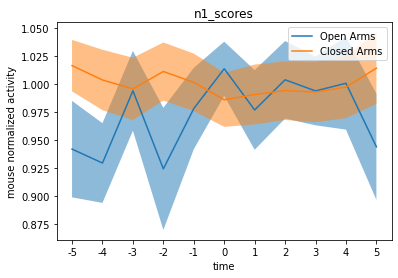

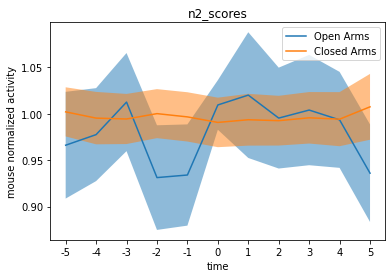

In [65]:
for score_type in ["n1_scores","n2_scores"]:
    oa_scores = []
    ca_scores = []
    t6_oa = []
    t6_ca = []
    for mouse in np.unique(stats_df.mouse):
        mouse_oa_mask = np.logical_and(stats_df.mouse==mouse,
                                       stats_df.openArms==1)
        mouse_ca_mask = np.logical_and(stats_df.mouse==mouse,
                                   stats_df.openArms==0)
        
        if np.sum(mouse_oa_mask) > 0 and np.sum(mouse_ca_mask) > 0:
            six_point_oa = stats_df[mouse_oa_mask==1][score_type].values[5]
            six_point_ca = stats_df[mouse_ca_mask==1][score_type].values[5]
            six_point_mean = np.mean([six_point_oa,six_point_ca])

            oa_scores.append(stats_df[mouse_oa_mask==1][score_type].values / six_point_mean)#/ stats_df[np.logical_and(mouse_oa_mask,
                                                                                                    #stats_df.time==6)]["bxcx_n1_scores"])
            ca_scores.append(stats_df[mouse_ca_mask==1][score_type].values / six_point_mean)  #/ stats_df[np.logical_and(mouse_ca_mask,

    
    
    oa_scores = np.array(oa_scores)
    oa_mean = np.nanmean(oa_scores,axis=0)
    oa_std = np.nanstd(oa_scores,axis=0) / np.sqrt(11)

    ca_scores = np.array(ca_scores)
    ca_mean = np.nanmean(ca_scores,axis=0) 
    ca_std = np.nanstd(ca_scores,axis=0) / np.sqrt(11)
    #print(wilcoxon(oa_scores[:,5],ca_scores[:,6]))
    
    plt.plot(oa_mean,label="Open Arms")
    plt.fill_between(range(11),oa_mean+oa_std,oa_mean-oa_std,alpha=0.5)
    plt.plot(ca_mean,label="Closed Arms")
    plt.fill_between(range(11),ca_mean+ca_std,ca_mean-ca_std,alpha=0.5)
    plt.xticks(range(11),np.arange(11) - 5)
    plt.xlabel('time')
    plt.ylabel('mouse normalized activity')
    plt.title(score_type)
    plt.legend()
    plt.show()

In [83]:
max_size = 300
n_mice = 21
network_score_matrices = []
for net_type in ["net 1 scores","net 2 scores", "net 3 scores"]:
    score_matrix = np.zeros((np.unique(df_in_task.mouse).shape[0],max_size)) * np.nan
    mouse_hc_mean_scores = []
    mouse_geno_list = []
    
    for idx,mouse in enumerate(np.unique(df_in_task.mouse)):
        geno = df_in_task[df_in_task.mouse==mouse]["condition (1:CLOCK,0:WT)"].values[0]
        mouse_geno_list.append(geno)
        mouse_mask = df_in_task.mouse==mouse
        mouse_start_time = np.min(df_in_task[mouse_mask==1].time)
        mouse_max_time = mouse_start_time + max_size
        time_mask = np.logical_and(df_in_task.time >= mouse_start_time, df_in_task.time < mouse_max_time)
        mask= np.logical_and(mouse_mask,time_mask)
        
        closed_arms = np.logical_or(df_in_task[mask==1]["roi"].values==1,
                                    df_in_task[mask==1]["roi"].values==3)
        drop_mask = 1 - closed_arms
        
        nan_mask = np.ones(closed_arms.shape)
        nan_mask[drop_mask==1]=np.nan

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


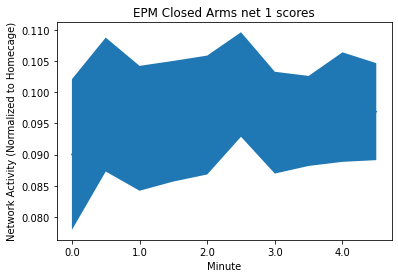

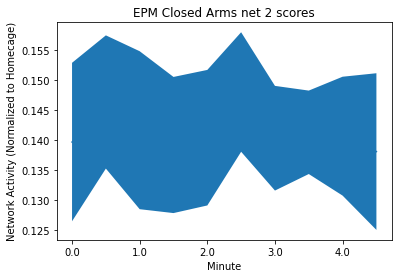

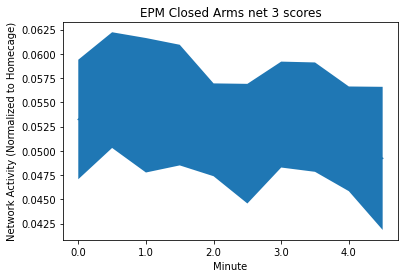

In [84]:
max_size = 300
n_mice = 21
network_score_matrices = []
for net_type in ["net 1 scores","net 2 scores", "net 3 scores"]:
    score_matrix = np.zeros((np.unique(df_in_task.mouse).shape[0],max_size)) * np.nan
    mouse_hc_mean_scores = []
    mouse_geno_list = []
    
    for idx,mouse in enumerate(np.unique(df_in_task.mouse)):
        geno = df_in_task[df_in_task.mouse==mouse]["condition (1:CLOCK,0:WT)"].values[0]
        mouse_geno_list.append(geno)
        mouse_mask = df_in_task.mouse==mouse
        mouse_start_time = np.min(df_in_task[mouse_mask==1].time)
        mouse_max_time = mouse_start_time + max_size
        time_mask = np.logical_and(df_in_task.time >= mouse_start_time, df_in_task.time < mouse_max_time)
        mask= np.logical_and(mouse_mask,time_mask)
        
        
        closed_arms = np.logical_or(df_in_task[mask==1]["roi"].values==1,
                                    df_in_task[mask==1]["roi"].values==3)
        drop_mask = 1 - closed_arms
        
        nan_mask = np.ones(closed_arms.shape)
        nan_mask[drop_mask==1]=np.nan
        
        
        scores = df_in_task[mask==1][net_type]*nan_mask #/ np.nanmean(df_in_hc[df_in_hc.mouse==mouse][net_type])
        times = df_in_task[mask==1].time - df_in_task[mask==1].time.values[0]
        mouse_hc_mean_scores.append(np.nanmean(df_in_hc[df_in_hc.mouse==mouse][net_type].values))
        keep_scores = []
        for time in range(max_size):
            if time in list(times):
                score_idx = np.where(times==time)[0][0]
                keep_scores.append(scores.values[score_idx])
            else:
                keep_scores.append(np.nan)
                
        keep_scores = np.array(keep_scores)
        
        #keep_scores = [scores[np.where(times==time)[0][0]] if time in times else np.nan for time in range(300)]
        
        score_matrix[idx,:] = keep_scores
        
    saveMat = np.hstack([np.unique(df_in_task.mouse).reshape(-1,1),
                         np.array(mouse_geno_list).reshape(-1,1),
                         np.array(mouse_hc_mean_scores).reshape(-1,1),
                         score_matrix]).astype(object)
    df_temp = pd.DataFrame(saveMat,
                           columns = ["mouse","geno","HC_mean_scores"] + list(np.arange(1,301).astype(str)))
    network_score_matrices.append(df_temp)
    df_temp.to_csv(PROJECT_PATH + "complete_may_2024" + "_".join(net_type.split(" ")) + "_CD19EPM_closed_arm_scores_over_time_w_HC_mean.csv")
    second_averages = 30
    mean = np.nanmean(np.nanmean(score_matrix.reshape(n_mice,-1,second_averages),axis=2),axis=0)
    sterr = np.nanstd(np.nanmean(score_matrix.reshape(n_mice,-1,second_averages),axis=2),axis=0) / np.sqrt(9)
    plt.plot(mean)
    plt.fill_between(range(int(max_size/second_averages)),mean + sterr, mean - sterr)
    
    #plt.xticks(np.arange(int(max_size/second_averages)), np.arange(0,max_size,int(max_size/second_averages)))
    plt.title("EPM Closed Arms "+net_type)
    plt.ylabel("Network Activity")
    plt.xlabel("Network Activity")
    plt.xticks(np.arange(0,10,2),np.arange(0,10,2)*30/60)
    plt.xlabel("Minute")
    plt.ylabel("Network Activity (Normalized to Homecage)")
    #plt.ylim([1.2,2.2])
    plt.show()

In [80]:
score_matrix.shape

(21, 300)

In [79]:
score_matrix.shape

(21, 300)

In [85]:
1 - np.isnan(score_matrix[1,:])

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [90]:
closed_arms.astype(int)

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [94]:
nan_mask

array([ 1.,  1.,  1.,  1.,  1., nan, nan, nan, nan, nan,  1.,  1.,  1.,
        1.,  1., nan, nan,  1.,  1.,  1.,  1.,  1.,  1., nan,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., nan, nan, nan, nan,  1.,  1.,  1.,
        1.,  1.,  1., nan, nan, nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., nan, nan, nan, nan, nan, nan, nan, nan,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., nan, nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan,  1.,  1.,  1

In [97]:
1 - np.isnan(score_matrix[-1,:])

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])